In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import itertools as itt
import matplotlib.pyplot as plt
import numpy as np
from sdeint import itoint
from spynal.spectra.multitaper import multitaper_spectrogram
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from sklearn.decomposition import PCA
import sys
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *

sys.path.append('../..')
from plot_utils import *

In [3]:
def f(x, t, A):
    return A @ x

def G(x, t, noise_scale):
    return np.eye(x.shape[0])*noise_scale

# Low Dim Linear System

In [669]:
def simulate_system(decay_rate, freq, t_span=[0, 5], dt=0.0005, num_trajs=2, noise_scale=0, verbose=False):
    np.random.seed(42)
    Lambda = np.array([[-decay_rate, freq*2*np.pi], [-freq*2*np.pi, -decay_rate]])
    V = np.random.randn(Lambda.shape[-1], Lambda.shape[-1])
    
    A = V @ Lambda @ np.linalg.inv(V)
    
    t_eval = np.arange(t_span[0], t_span[1], dt)
    T = len(t_eval)
    
    n = A.shape[-1]
    
    x = np.zeros((num_trajs, T, n))

    for num_traj in range(num_trajs):
        y0 = np.random.randn(n)
        if noise_scale == 0:
            sol = solve_ivp(lambda t, x: f(x, t, A=A), y0=y0, t_span=t_span, t_eval=t_eval)
            x[num_traj] = sol.y.T
        else:
            x[num_traj] = itoint(lambda x, t: f(x, t, A=A), lambda x, t: G(x, t, noise_scale=noise_scale), y0, t_eval)
        
    # dW = np.random.randn(*x.shape)
    # x[:, 0] = np.random.randn(num_trajs, n)
    # for t in tqdm(range(1, T), disable=not verbose, desc='Simulating System'):
        # x[:, t] = x[:, t-1] + dt*(A@x[:, t-1].T).T + np.sqrt(dt)*noise_scale*dW[:, t]
        

    return x, t_eval

def compute_spectrum(x, dt):
    freqs = np.fft.rfftfreq(x.shape[1], d=dt)
    ffts = np.fft.rfft(x.transpose(0, 2, 1).reshape(x.shape[0]*x.shape[2], x.shape[1]))
    ffts = ffts.reshape(x.shape[0], x.shape[2], -1) # trials x inds x freqs
    fft_mags = np.abs(ffts)
    fft_angles = np.angle(ffts)

    return ffts, freqs, fft_mags, fft_angles

def compute_spectra(x, dt, time_width=0.5):
    spec, freqs_spec, time_pts = multitaper_spectrogram(x.transpose(1, 0, 2).reshape(x.shape[1], -1), 1/dt, time_width=time_width)
    spec = spec.reshape(spec.shape[0], spec.shape[1], x.shape[0], x.shape[2]).transpose(2, 3, 0, 1) # trials x inds x freqs x time
    spec_mags = np.abs(spec)
    spec_angles = np.angle(spec)

    return spec, freqs_spec, spec_mags, spec_angles

In [6]:
t_span = [0, 5]
dt = 0.001
num_trajs = 10
noise_scale = 0
time_width = 1

# More stable, and delta

In [11]:
decay_rate = 0.1
freq = 4

x, t_eval = simulate_system(decay_rate, freq, t_span, dt, num_trajs, noise_scale)
ffts, freqs, fft_mags, fft_angles = compute_spectrum(x, dt)
# spec, freqs_spec, spec_mags, spec_angles = compute_spectra(x, dt, time_width=time_width)

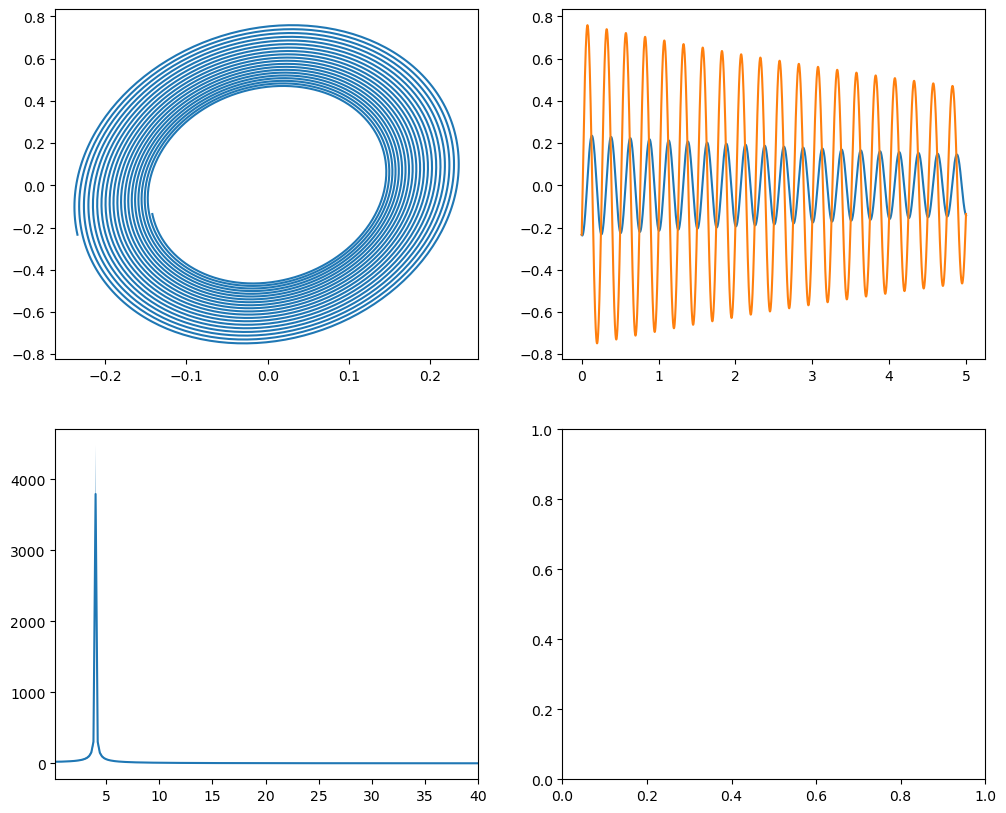

In [12]:
max_freq = 40
min_freq = freqs[1]

traj_num = 0
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0][0]
ax.plot(x[traj_num, :, 0], x[traj_num, :, 1])

ax = axs[0][1]
ax.plot(t_eval, x[traj_num, :, 0])
ax.plot(t_eval, x[traj_num, :, 1])

ax = axs[1][0]
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 0])
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 1])
mean_vals = fft_mags.mean(axis=(0, 1))
se_vals = fft_mags.std(axis=(0, 1))/np.sqrt(fft_mags.shape[0]*fft_mags.shape[1])
ax.plot(freqs, mean_vals)
ax.fill_between(freqs, mean_vals - se_vals, mean_vals + se_vals, alpha=0.5)

ax.set_xlim([min_freq, max_freq])

ax = axs[1][1]
# ax.imshow(spec_mags.mean(axis=(0, 1)), aspect='auto', origin='lower')
# min_ind = np.argmax(freqs_spec >= min_freq)
# max_ind = np.argmin(freqs_spec <= max_freq)
# ax.set_ylim([min_ind, max_ind])
# yticks = ax.get_yticks()
# ylim = ax.get_ylim()
# yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
# yticklabels = [f"{freqs_spec[int(y)]:.3f}" for y in yticks]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)

plt.show()

# Less stable, and gamma

In [14]:
decay_rate = 0.01
freq = 30

x, t_eval = simulate_system(decay_rate, freq, t_span, dt, num_trajs, noise_scale)
ffts, freqs, fft_mags, fft_angles = compute_spectrum(x, dt)
# spec, freqs_spec, spec_mags, spec_angles = compute_spectra(x, dt, time_width=time_width)

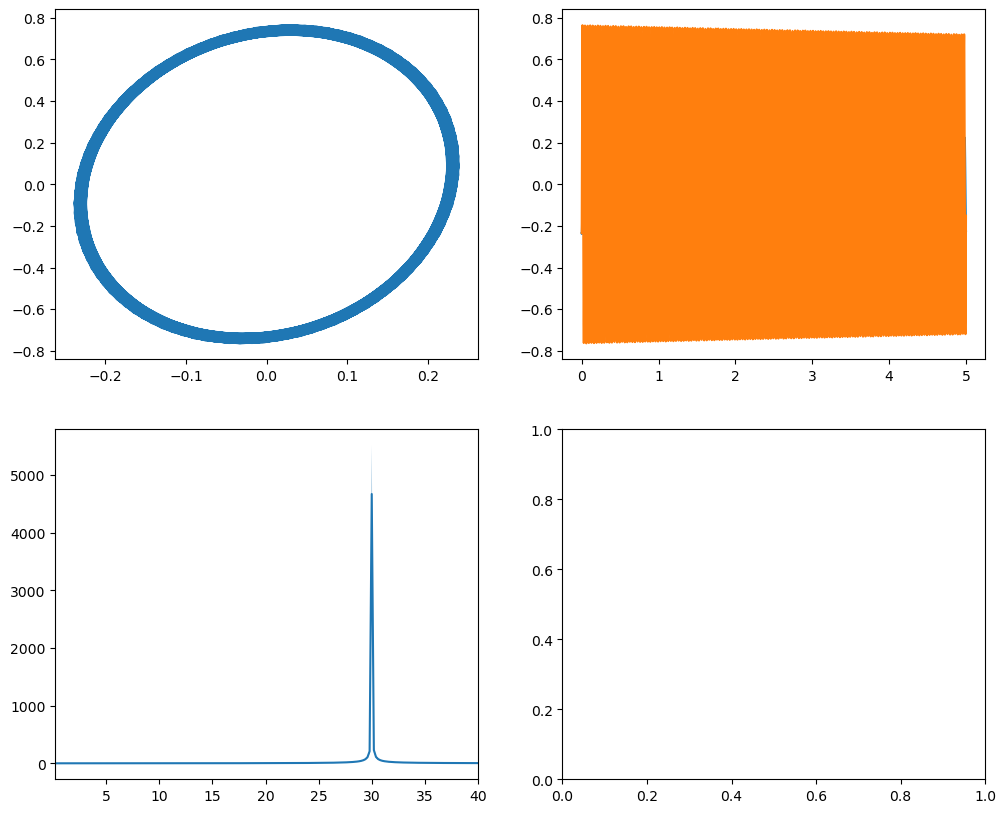

In [15]:
max_freq = 40
min_freq = freqs[1]

traj_num = 0
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0][0]
ax.plot(x[traj_num, :, 0], x[traj_num, :, 1])

ax = axs[0][1]
ax.plot(t_eval, x[traj_num, :, 0])
ax.plot(t_eval, x[traj_num, :, 1])

ax = axs[1][0]
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 0])
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 1])
mean_vals = fft_mags.mean(axis=(0, 1))
se_vals = fft_mags.std(axis=(0, 1))/np.sqrt(fft_mags.shape[0]*fft_mags.shape[1])
ax.plot(freqs, mean_vals)
ax.fill_between(freqs, mean_vals - se_vals, mean_vals + se_vals, alpha=0.5)

ax.set_xlim([min_freq, max_freq])

ax = axs[1][1]
# ax.imshow(spec_mags.mean(axis=(0, 1)), aspect='auto', origin='lower')
# min_ind = np.argmax(freqs_spec >= min_freq)
# max_ind = np.argmin(freqs_spec <= max_freq)
# ax.set_ylim([min_ind, max_ind])
# yticks = ax.get_yticks()
# ylim = ax.get_ylim()
# yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
# yticklabels = [f"{freqs_spec[int(y)]:.3f}" for y in yticks]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)

plt.show()

# Van Der Pol Oscillator

In [16]:
def vdp(t, x, mu):
    x, y = x
    dxdt = y
    dydt = mu*(1 - x**2)*y - x

    return np.array([dxdt, dydt])

In [34]:
# mu = 3
mu = 45

In [35]:
mu = 45
t_span = [0, 200]
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)
T = len(t_eval)


In [36]:
np.random.seed(42)
num_trajs = 1
x = np.zeros((num_trajs, T, 2))

for num_traj in tqdm(range(num_trajs)):
    y0 = np.random.randn(2)
    sol = solve_ivp(lambda t, x: vdp(t, x, mu=mu), y0=y0, t_span=t_span, t_eval=t_eval)
    x[num_traj] = sol.y.T

  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
time_width = 20
transient = int(T*0.1)
ffts, freqs, fft_mags, fft_angles = compute_spectrum(x[:, transient:], dt)
# spec, freqs_spec, spec_mags, spec_angles = compute_spectra(x[:, transient:], dt, time_width=time_width)

In [38]:
pred_period = (3 - 2*np.log(2))*mu + 2*np.pi/(mu**(1/3))

In [41]:
x.shape

(1, 200000, 2)

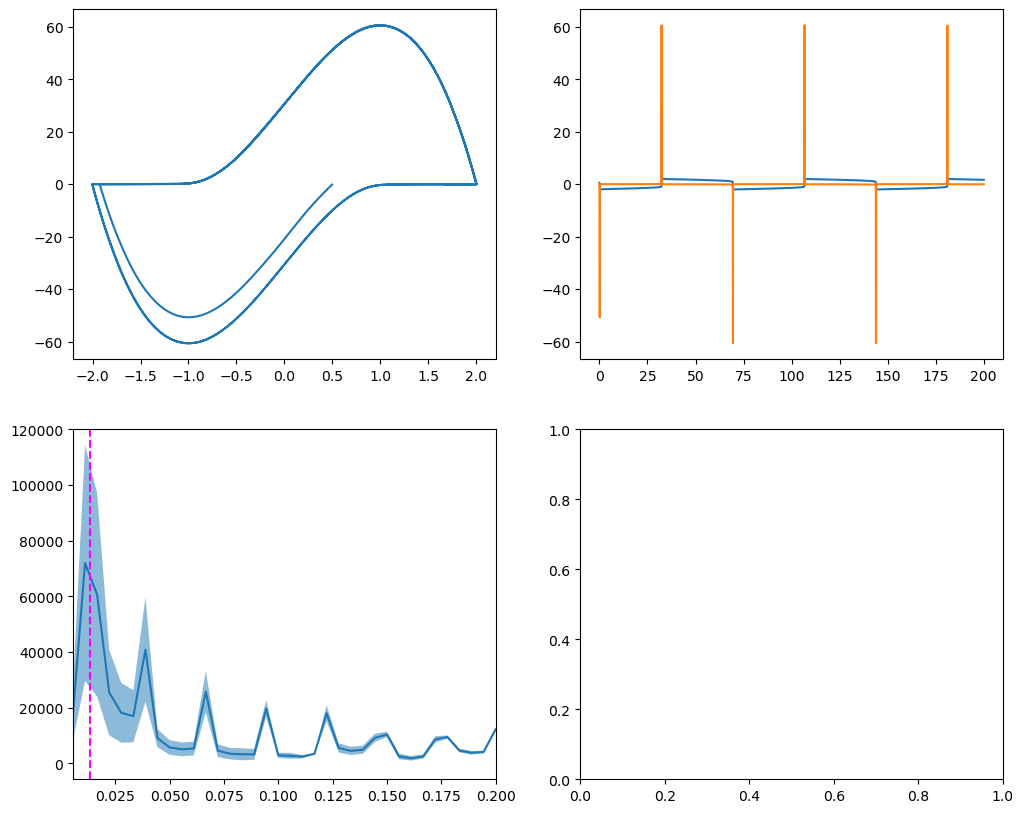

In [40]:
max_freq = 0.2
min_freq = freqs[1]
# min_freq = np.min([freqs[1], freqs_spec[1]])

traj_num = 0
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0][0]
ax.plot(x[traj_num, :, 0], x[traj_num, :, 1])

ax = axs[0][1]
ax.plot(t_eval, x[traj_num, :, 0])
ax.plot(t_eval, x[traj_num, :, 1])

ax = axs[1][0]
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 0])
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 1])
mean_vals = fft_mags.mean(axis=(0, 1))
se_vals = fft_mags.std(axis=(0, 1))/np.sqrt(fft_mags.shape[0]*fft_mags.shape[1])
ax.plot(freqs, mean_vals)
ax.fill_between(freqs, mean_vals - se_vals, mean_vals + se_vals, alpha=0.5)
ax.axvline(1/pred_period, linestyle='--', c='magenta')
ax.set_xlim([min_freq, max_freq])

ax = axs[1][1]
# ax.imshow(spec_mags.mean(axis=(0, 1)), aspect='auto', origin='lower')
# min_ind = np.argmax(freqs_spec >= min_freq)
# max_ind = np.argmin(freqs_spec <= max_freq)
# ax.set_ylim([min_ind, max_ind])
# yticks = ax.get_yticks()
# ylim = ax.get_ylim()
# yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
# yticklabels = [f"{freqs_spec[int(y)]:.3f}" for y in yticks]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)
# ax.axhline((1/pred_period)/freqs_spec[1], linestyle='--', c='magenta')

plt.show()

In [222]:
mu_vals = np.linspace(1, 4, 1000)
period_vals = (3 - 2*np.log(2))*mu_vals + 2*np.pi/(mu_vals**(1/3))
freq_vals = 1/period_vals

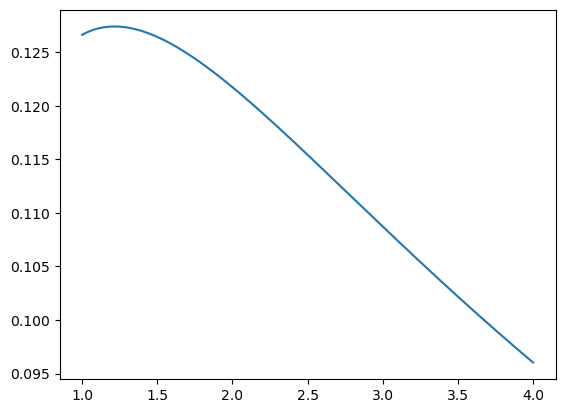

In [223]:
plt.plot(mu_vals, freq_vals)

# DeLASE on VDP

In [680]:
def damped_vdp(t, x, mu, gamma):
    x, y = x
    dxdt = y
    dydt = mu*(1 - x**2)*y - x - gamma*y

    return np.array([dxdt, dydt])

In [712]:
t_span = [0, 200]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
T = len(t_eval)
num_trajs = 2
# mus = [1, 2, 3, 4]
mus = [1, 2, 3, 4]
gammas = [0, 2.05]
# gammas = [0, 3]

# noise_scale = 0.01
noise_scale = 0.005

trajectories = {}

iterator = tqdm(total=num_trajs*len(mus)*len(gammas))

for mu in mus:
    for gamma in gammas:
        np.random.seed(42)
        
        x = np.zeros((num_trajs, T, 2))
        
        for num_traj in range(num_trajs):
            y0 = np.random.randn(2)
            if noise_scale == 0:
                sol = solve_ivp(lambda t, x: damped_vdp(t, x, mu=mu, gamma=gamma), y0=y0, t_span=t_span, t_eval=t_eval)
                x[num_traj] = sol.y.T
            else:
                x[num_traj] = itoint(lambda x, t: damped_vdp(t, x, mu=mu, gamma=gamma), lambda x, t: G(x, t, noise_scale=noise_scale), y0, t_eval)

            iterator.update()

        trajectories[(mu, gamma)] = x
iterator.close()

  0%|          | 0/16 [00:00<?, ?it/s]

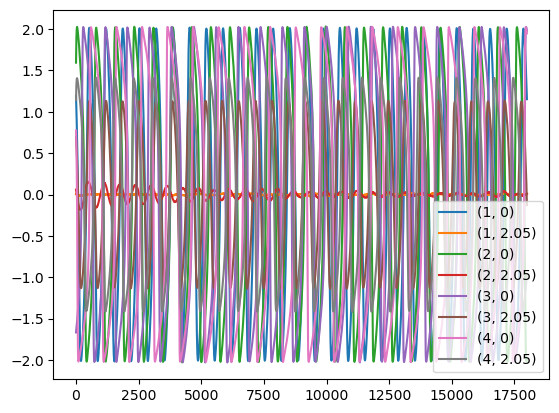

In [713]:
for key, val in trajectories.items():
    mu, gamma = key
    # if mu in [4] and gamma == 2.05:
    plt.plot(val[0][:, 0][transient:], label=f"{key}")
plt.legend()
plt.show()

In [714]:
subsample = 1
max_freq = (1/(dt*subsample))/2
n_delays_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50]
rank_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

all_delase_results = []

iterator = tqdm(total=num_trajs*len(mus)*len(gammas)*len(n_delays_vals)*len(rank_vals))

for num_traj in range(num_trajs):
    # print("-"*20)
    # print(f"NUM_TRAJ = {num_traj}")
    delase_results = {}
    
    for mu in mus:
        for gamma in gammas:
            # print("-"*20)
            # print(f"MU = {mu}")
            x = trajectories[(mu, gamma)]
            x = x[num_traj, ::subsample]
            x = x[:, [1]]
            
            transient = int(x.shape[0]*0.1)
            train_inds = np.arange(transient, int(x.shape[0]*0.75))
            test_inds = np.arange(int(x.shape[0]*0.75), x.shape[0])
            
            aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
            
            for i, n_delays in enumerate(n_delays_vals):
                for j, rank in enumerate(rank_vals):
                    if rank <= n_delays*x.shape[-1]:
                        delase = DeLASE(x[train_inds], n_delays=n_delays, rank=rank, dt=dt*subsample, device='cuda')
                        delase.DMD.fit()
                        preds = delase.DMD.predict(x[test_inds])
                        aic_mat[i, j] = float(aic(torch.from_numpy(x[test_inds]).cuda(), preds, k=rank**2).cpu().numpy())
                    else:
                        aic_mat[i, j] = np.Inf
                    iterator.update()
        
            delase_results[(mu, gamma)] = dict(
                train_inds=train_inds,
                test_inds=test_inds,
                aic_mat=aic_mat,
            )

    all_delase_results.append(delase_results)
    
iterator.close()

  0%|          | 0/2016 [00:00<?, ?it/s]

In [715]:
pairs_to_use = [(1, 0), (2, 0), (3, 0), (1, 2.05), (2, 2.05)]

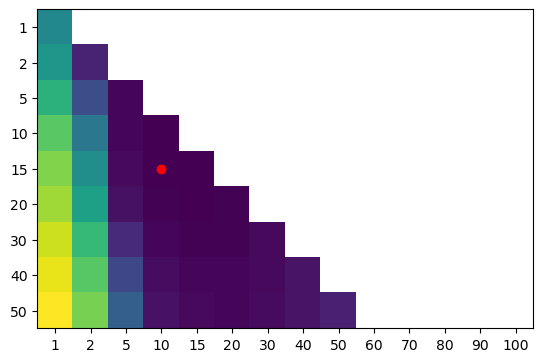

In [716]:
aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for mu in mus:
        for gamma in gammas:
            if (mu, gamma) in pairs_to_use:
                aic_mat += delase_results[(mu, gamma)]['aic_mat']
aic_mat /= len(pairs_to_use)
i, j = np.unravel_index(aic_mat.argmin(), shape=aic_mat.shape)
n_delays = n_delays_vals[i]
rank = rank_vals[j]

plt.imshow(aic_mat)
plt.scatter(j, i, c='r')
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.show()

for num_traj in range(num_trajs):
    for mu in mus:
        for gamma in gammas:
            if (mu, gamma) in pairs_to_use:
                # print("-"*20)
                # print(f"MU = {mu}")
                x = trajectories[(mu, gamma)]
                x = x[num_traj, ::subsample]
                x = x[:, [1]]
                
                transient = int(x.shape[0]*0.1)
                train_inds = np.arange(transient, int(x.shape[0]*0.75))
                test_inds = np.arange(int(x.shape[0]*0.75), x.shape[0])
            
                delase = DeLASE(x[train_inds], n_delays = n_delays, rank=rank, dt=dt*subsample, device='cuda', max_freq=max_freq, max_unstable_freq=max_freq)
                delase.fit()
                delase.to('cpu')
                preds = delase.DMD.predict(x[test_inds])
            
                all_delase_results[num_traj][(mu, gamma)] = all_delase_results[num_traj][(mu, gamma)] | dict(delase=delase, n_delays=n_delays, rank=rank)
    
    # for mu in mus[:-1]:
    #     stab_params = delase_results[mu]['delase'].stability_params.cpu()
    #     plt.plot(stab_params[:int(0.1*len(stab_params))], label=fr"$\mu$ = {mu}")
    # plt.legend()
    # plt.show()


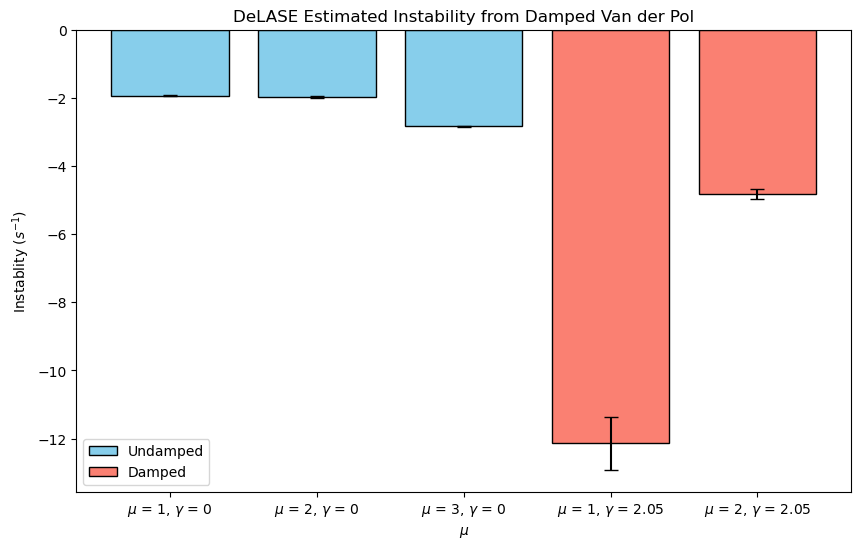

In [726]:
plt.figure(figsize=(10, 6))

stab_means = np.zeros((num_trajs, len(pairs_to_use)))

for num_traj, delase_results in enumerate(all_delase_results):
    labels = []
    for ind, (mu, gamma) in enumerate(pairs_to_use):
        stab_params = delase_results[(mu, gamma)]['delase'].stability_params
        # stab_means[num_traj, ind] = stab_params[:int(0.1*len(stab_params))].mean()
        # stab_means[num_traj, ind] = stab_params[:2].mean()
        # print(int(0.2*len(stab_params)))
        stab_means[num_traj, ind] = stab_params[:int(0.2*len(stab_params))].mean()

# Create the scatter plot with error bars
mean_vals = stab_means.mean(axis=0)
se_vals = stab_means.std(axis=0)/np.sqrt(stab_means.shape[0])

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
colors = ['skyblue' if gamma == 0 else 'salmon' for _, gamma in pairs_to_use]
plt.bar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
plt.xticks(np.arange(len(pairs_to_use)), [fr"$\mu$ = {mu}, $\gamma$ = {gamma}" for mu,gamma in pairs_to_use])

plt.xlabel("$\mu$")
plt.ylabel("Instablity ($s^{-1}$)")

plt.title("DeLASE Estimated Instability from Damped Van der Pol")

# Create legend
legend_labels = {'undamped': 'Undamped', 'damped': 'Damped'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['undamped']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['damped'])]
plt.legend(handles=legend_handles, loc='lower left')

# Display the plot
# clear_axes(plt.gca())
plt.show()

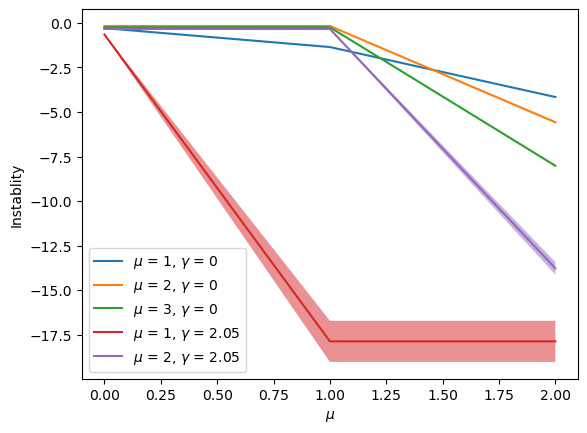

In [727]:
top_percent = 0.2

stab_means = np.zeros((num_trajs, len(pairs_to_use), int(top_percent*len(stab_params))))

for num_traj, delase_results in enumerate(all_delase_results):
    labels = []
    for ind, (mu, gamma) in enumerate(pairs_to_use):
        stab_params = delase_results[(mu, gamma)]['delase'].stability_params
        stab_means[num_traj, ind] = stab_params[:int(top_percent*len(stab_params))].cpu()

# Create the scatter plot with error bars
mean_vals = stab_means.mean(axis=0)
se_vals = stab_means.std(axis=0)/np.sqrt(stab_means.shape[0])

for ind, (mu, gamma) in enumerate(pairs_to_use):
    plt.plot(mean_vals[ind], label=fr"$\mu$ = {mu}, $\gamma$ = {gamma}")
    plt.fill_between(np.arange(len(mean_vals[ind])), mean_vals[ind] - se_vals[ind], mean_vals[ind] + se_vals[ind], alpha=0.5)
plt.xlabel("$\mu$")
plt.ylabel("Instablity")
# Display the plot
plt.legend()
plt.show()

# High-dimensional Linear Systems


In [191]:
def simulate_system_hd(decay_rate, freq,  n=10, t_span=[0, 5], dt=0.001, num_trajs=2, noise_scale=0, time_scaling=1, verbose=False):
    np.random.seed(42)
    Lambda = np.zeros((n, n))
    Lambda[:2][:, :2] = np.array([[-decay_rate, freq*2*np.pi], [-freq*2*np.pi, -decay_rate/time_scaling]])
    # max_decay = -20*decay_rate
    # min_decay = -30*decay_rate
    # max_decay = -2*(1e-3)
    # min_decay = -4*(1e-3)
    max_decay = -6
    min_decay = -10
    extra_decay_rates = np.random.uniform(min_decay, max_decay, size=int((n - 2)/2))
    # extra_freqs = np.random.uniform(0.5*time_scaling, 40*time_scaling, size=int((n - 2)/2))
    extra_freqs = np.random.uniform(0.1*time_scaling, 0.5*time_scaling, size=int((n - 2)/2))
    for i in range(1, int((n - 2)/2)+1):
        Lambda[2*i:2*i + 2][:, 2*i:2*i + 2] = np.array([[extra_decay_rates[i-1], extra_freqs[i-1]*2*np.pi], [-extra_freqs[i-1]*2*np.pi, extra_decay_rates[i-1]]])
    
    V = np.random.randn(Lambda.shape[-1], Lambda.shape[-1])*(1/np.sqrt(n))
    # V = np.eye(Lambda.shape[-1])
    
    A = V @ Lambda @ np.linalg.inv(V)
    
    t_eval = np.arange(t_span[0], t_span[1], dt)
    T = len(t_eval)
    
    n = A.shape[-1]

    evals = np.linalg.eigvals(A)
    plt.scatter(np.real(evals), np.imag(evals))
    
    x = np.zeros((num_trajs, T, n))

    # for num_traj in range(num_trajs):
    #     y0 = np.random.randn(n)
    #     if noise_scale == 0:
    #         sol = solve_ivp(lambda t, x: f(x, t, A=A), y0=y0, t_span=t_span, t_eval=t_eval, first_step=dt)
    #         x[num_traj] = sol.y.T
    #     else:
    #         x[num_traj] = itoint(lambda x, t: f(x, t, A=A), lambda x, t: G(x, t, noise_scale=noise_scale), y0, t_eval)
        
    dW = np.random.randn(*x.shape)
    # x[:, 0] = np.random.randn(num_trajs, n)
    x[:, 0] = np.zeros((num_trajs, n))
    for t in tqdm(range(1, T), disable=not verbose, desc='Simulating System'):
        x[:, t] = x[:, t-1] + dt*(A@x[:, t-1].T).T + np.sqrt(dt)*noise_scale*dW[:, t]
        

    return x, t_eval

In [885]:
# t_span = [0, 20]
# dt = 0.001
# noise_scale = 0

t_span = [0, 10]
dt = 0.0005
noise_scale = 0.02
num_trajs = 2
time_width = 1

In [873]:
# decay_rate = 0.1
# freq = 4

decay_rate = 0.01
freq = 30

# decay_rate = 0.1
# freq = 30

n = 50

In [867]:
x, t_eval = simulate_system_hd(decay_rate, freq, n, t_span, dt, num_trajs, noise_scale)

In [662]:
ffts, freqs, fft_mags, fft_angles = compute_spectrum(x, dt)

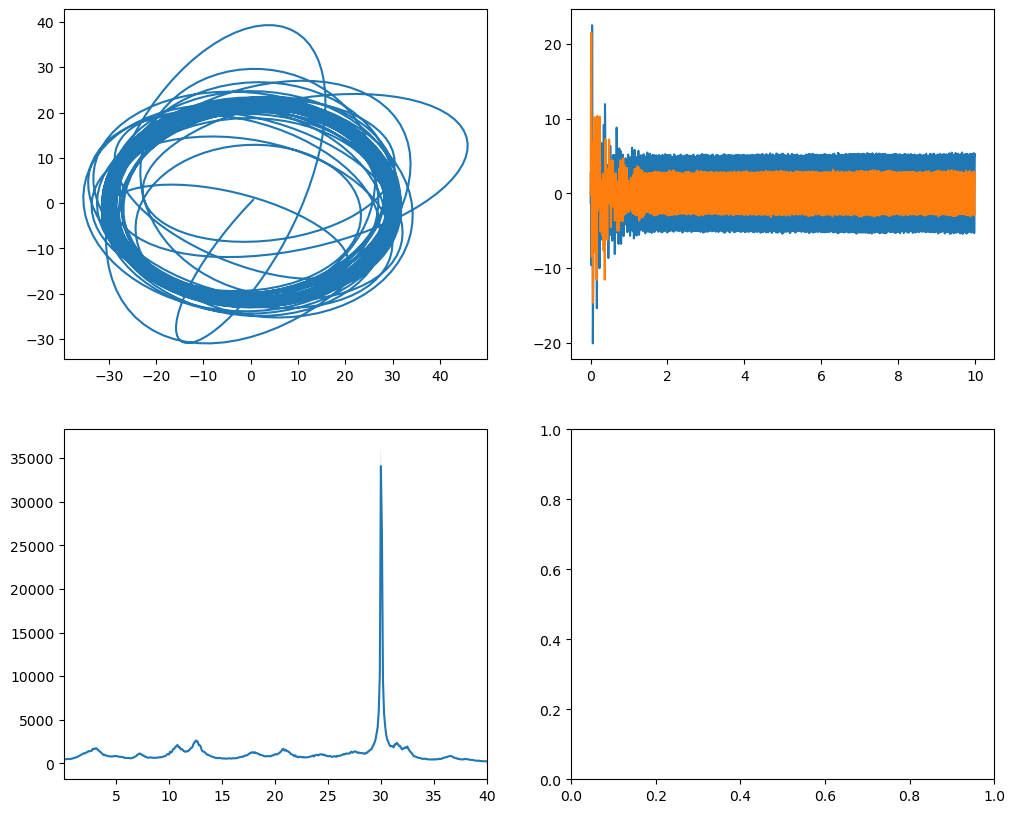

In [663]:
max_freq = 40
min_freq = freqs[1]

traj_num = 0
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax = axs[0][0]
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x.reshape(-1, x.shape[2]))
x_pca = x_pca.reshape(x.shape[0], x.shape[1], -1)
ax.plot(x_pca[traj_num, :, 0], x_pca[traj_num, :, 1])

ax = axs[0][1]
ax.plot(t_eval, x[traj_num, :, 0])
ax.plot(t_eval, x[traj_num, :, 1])

ax = axs[1][0]
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 0])
# ax.plot(freqs, fft_mags.mean(axis=0)[:, 1])
mean_vals = fft_mags.mean(axis=(0, 1))
se_vals = fft_mags.std(axis=(0, 1))/np.sqrt(fft_mags.shape[0]*fft_mags.shape[1])
ax.plot(freqs, mean_vals)
ax.fill_between(freqs, mean_vals - se_vals, mean_vals + se_vals, alpha=0.5)

ax.set_xlim([min_freq, max_freq])

ax = axs[1][1]
# ax.imshow(spec_mags.mean(axis=(0, 1)), aspect='auto', origin='lower')
# min_ind = np.argmax(freqs_spec >= min_freq)
# max_ind = np.argmin(freqs_spec <= max_freq)
# ax.set_ylim([min_ind, max_ind])
# yticks = ax.get_yticks()
# ylim = ax.get_ylim()
# yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]
# yticklabels = [f"{freqs_spec[int(y)]:.3f}" for y in yticks]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)

plt.show()

# DeLASE with High-dimensional Linear System

In [205]:
# Let's say the time values are in milliseconds (why not !?)
# Then a frequency of 30 is actually 30,000 Hz, and t_span=20 is actually 20 ms !
# So let's reframe, let's say milliseconds - so 30 Hz would be 0.03 cycles / ms and 4 Hz would be 0.004
# decay rate of 1 ms{-1} is actually a decay rate of 1000 s{-1}
# thus to get a decay of ~10 s, we need 1/10 s{-1} => 1/10,000 ms{-1]
# Then let's simulate for 2 seconds - ie 2000 ms !
# and we'll use dt = 0.1 = one tenth of a millisecond = 1/10,000th of a second !
# For a time step, lets use a ms
# decay_rates = [4, 0]

# decay_rates = [0]
# t_span = [0, 3000]

# # NEW TIME SCALING
# time_scaling = 0.001 # ms = time step / s
# decay_rates = [1e-4, 0.05]
# freqs = [0.03, 0.004]
# t_span = [0, 9000]
# dt = 0.1
# noise_scale = 1e-4
# obs_noise = 5e-3
# num_trajs = 10
# time_width = 1

# BACK TO OLD TIME SCALING
# decay_rates = [0.01, 0.08]
# freqs = [30, 4]
time_scaling = 1 # 
decay_rates = [0.1, 0.3, 0.5]
freqs = [0.04, 0.3]
t_span = [0, 40]
dt = 1e-3
noise_scale = 0.1
obs_noise = 0
num_trajs = 1
time_width = 1

n = 100
subsample = 1

# decay_rates = [5, 10]

# OLD
# # decay_rates = [4, 0]
# decay_rates = [0.1]
# freqs = [0.03, 0.004]

# # t_span = [0, 10]
# # dt = 0.0005
# # noise_scale = 0.02
# # num_trajs = 2
# # time_width = 1

# t_span = [0, 20]
# dt = 0.001
# noise_scale = 0
# num_trajs = 2
# time_width = 1


  0%|          | 0/6 [00:00<?, ?it/s]

Simulating System:   0%|          | 0/39999 [00:00<?, ?it/s]

Simulating System:   0%|          | 0/39999 [00:00<?, ?it/s]

Simulating System:   0%|          | 0/39999 [00:00<?, ?it/s]

Simulating System:   0%|          | 0/39999 [00:00<?, ?it/s]

Simulating System:   0%|          | 0/39999 [00:00<?, ?it/s]

Simulating System:   0%|          | 0/39999 [00:00<?, ?it/s]

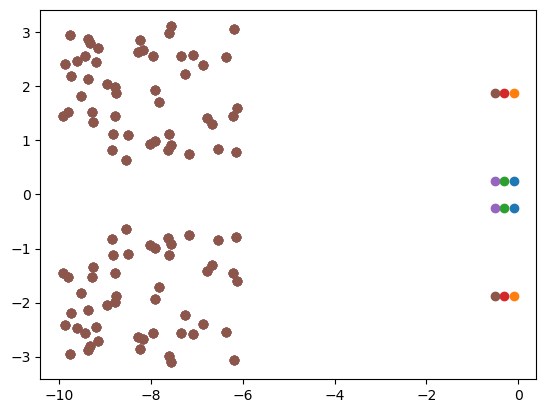

In [206]:
trajectories = {}

iterator = tqdm(total=len(decay_rates)*len(freqs))

for decay_rate in decay_rates:
    for freq in freqs:
        x, t_eval = simulate_system_hd(decay_rate, freq, n, t_span, dt, num_trajs, noise_scale, time_scaling, verbose=True)
        trajectories[(decay_rate, freq)] = x + np.random.randn(*x.shape)*obs_noise
        iterator.update()
iterator.close()

(1, 40000, 100)
13200
(1, 40000, 100)
13200
(1, 40000, 100)
13200
(1, 40000, 100)
13200
(1, 40000, 100)
13200
(1, 40000, 100)
13200


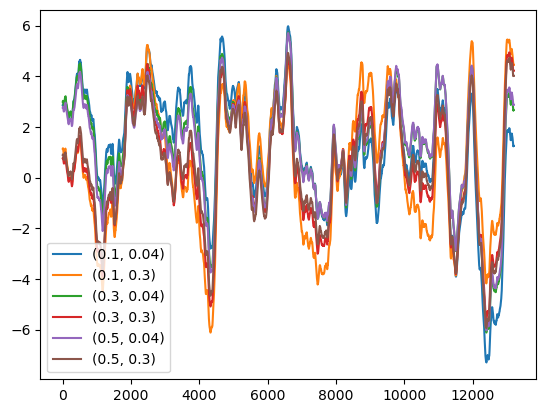

In [207]:
for key, x in trajectories.items():
    print(x.shape)
    decay_rate, freq = key
    x = x[:, ::subsample]
    transient = int(x.shape[1]*0.33)
    print(transient)
    # transient = 0
    # pca = PCA(n_components=2)
    # x_pca = pca.fit_transform(x.reshape(-1, x.shape[2]))
    # x_pca = x_pca.reshape(x.shape[0], x.shape[1], -1)
    # # plt.plot(x_pca[0][:, 0][transient:], x_pca[0][:, 1][transient:], label=f"{key}")
    # # plt.plot(x_pca[0][:, 0][transient:], label=f"{key}")
    # # if decay_rate == 0.05:
    # plt.plot(x_pca[0][:, 0][transient:transient + transient], label=f"{key}")
    plt.plot(x[0][:, 0][transient:transient + transient], label=f"{key}")
plt.legend()
plt.show()

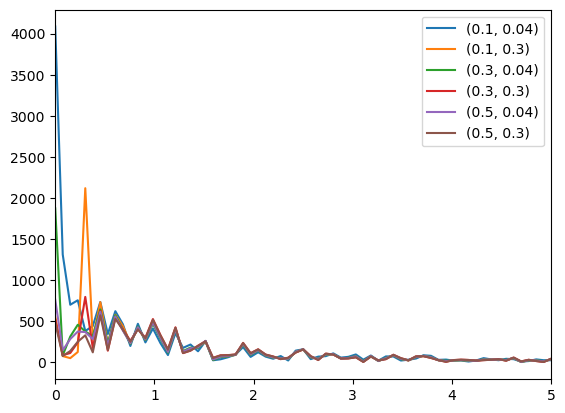

In [208]:
for key, x in trajectories.items():
    decay_rate, freq = key
    x = x[:, ::subsample]
    transient = int(x.shape[1]*0.33)


    fft_mag = np.abs(np.fft.rfft(x[0][transient:transient + transient].T).mean(axis=0))
    # fft_freq = np.fft.rfftfreq(transient, d=dt*time_scaling)
    fft_freq = np.fft.rfftfreq(transient, d=dt*subsample*time_scaling)
    plt.plot(fft_freq, fft_mag, label=key)
plt.xlim([0, 5])
plt.legend()
plt.show()

In [209]:
max_freq = (1/(dt*time_scaling*subsample))/2
n_delays_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50]
rank_vals = [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# matrix_size_vals=np.array([10, 20, 50]),
n_delays_vals = [1, 2, 3, 4, 5, 6, 8, 10]
r_vals=np.array([3, 5, 10, 25, 30, 40, 50, 60, 70, 80, 90, 100])

indices = np.arange(10)

all_delase_results = []

iterator = tqdm(total=num_trajs*len(decay_rates)*len(freqs)*len(n_delays_vals)*len(rank_vals))

for num_traj in range(num_trajs):
# for num_traj in [[0]]:
    # print("-"*20)
    # print(f"NUM_TRAJ = {num_traj}")
    delase_results = {}
    
    for decay_rate in decay_rates:
        for freq in freqs:
            # print("-"*20)
            # print(f"MU = {mu}")
            x = trajectories[(decay_rate, freq)]
            x = x[num_traj, ::subsample]
            x = x[:, indices]
            # mean, std = x.mean(), x.std()
            # x = (x - x.mean())/x.std()
            # x = x[:, [1]]
            
            transient = int(x.shape[0]*0.33)
            # transient = 0
            # train_inds = np.arange(transient, transient + int((x.shape[0] - transient)*0.7))
            train_inds = np.arange(transient, 2*transient)
            # test_inds = np.arange(transient + int((x.shape[0] - transient)*0.7), x.shape[0])
            test_inds = np.arange(2*transient, x.shape[0])
            
            aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
            
            for i, n_delays in enumerate(n_delays_vals):
                for j, rank in enumerate(rank_vals):
                    if rank <= n_delays*x.shape[-1]:
                        delase = DeLASE(x[train_inds], n_delays=n_delays, rank=rank, dt=dt*time_scaling*subsample, device='cuda')
                        delase.DMD.fit()
                        preds = delase.DMD.predict(x[test_inds])
                        aic_mat[i, j] = float(aic(torch.from_numpy(x[test_inds]).cuda(), preds, k=rank**2).cpu().numpy())
                    else:
                        aic_mat[i, j] = np.Inf
                    iterator.update()
        
            delase_results[(decay_rate, freq)] = dict(
                train_inds=train_inds,
                test_inds=test_inds,
                aic_mat=aic_mat,
            )

    all_delase_results.append(delase_results)
    
iterator.close()

  0%|          | 0/672 [00:00<?, ?it/s]

In [214]:
# pairs_to_use = [(1, 0), (2, 0), (3, 0), (4, 0), (1, 2.05), (2, 2.05)]
# pairs_to_use = [(dr, f) for dr, f in itt.product(decay_rates, freqs) if dr <= 0.3]
pairs_to_use = [(dr, f) for dr, f in itt.product(decay_rates, freqs)]

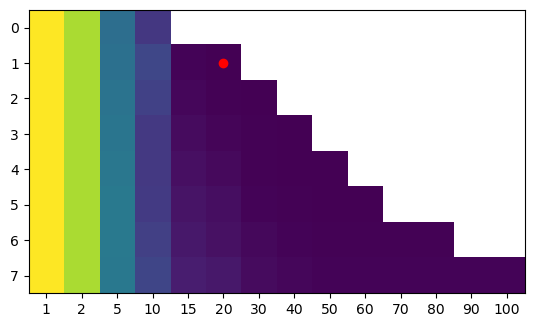

In [215]:
aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for decay_rate in decay_rates:
        for freq in freqs:
            if (decay_rate, freq) in pairs_to_use:
                aic_mat += delase_results[(decay_rate, freq)]['aic_mat']
aic_mat /= len(pairs_to_use)
i, j = np.unravel_index(aic_mat.argmin(), shape=aic_mat.shape)
n_delays = n_delays_vals[i]
rank = rank_vals[j]

plt.imshow(aic_mat)
plt.scatter(j, i, c='r')
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.show()

for num_traj in range(num_trajs):
    for decay_rate in decay_rates:
        for freq in freqs:
            if (decay_rate, freq) in pairs_to_use:
                # print("-"*20)
                # print(f"MU = {mu}")
                x = trajectories[(decay_rate, freq)]
                x = x[num_traj, ::subsample]
                x = x[:, indices]
                
                transient = int(x.shape[0]*0.33)
                # transient = 0
                # train_inds = np.arange(transient, transient + int((x.shape[0] - transient)*0.7))
                # test_inds = np.arange(transient + int((x.shape[0] - transient)*0.7), x.shape[0])
                train_inds = np.arange(transient, 2*transient)
                test_inds = np.arange(2*transient, x.shape[0])

                # n_delays, rank = parameters[num_traj]
                
                delase = DeLASE(x[train_inds], n_delays = n_delays, rank=rank, dt=dt*time_scaling*subsample, device='cuda', max_freq=max_freq, max_unstable_freq=max_freq)
                delase.fit()
                delase.to('cpu')
                preds = delase.DMD.predict(x[test_inds])
            
                all_delase_results[num_traj][(decay_rate, freq)] = all_delase_results[num_traj][(decay_rate, freq)] | dict(delase=delase, n_delays=n_delays, rank=rank)
    
    # for mu in mus[:-1]:
    #     stab_params = delase_results[mu]['delase'].stability_params.cpu()
    #     plt.plot(stab_params[:int(0.1*len(stab_params))], label=fr"$\mu$ = {mu}")
    # plt.legend()
    # plt.show()


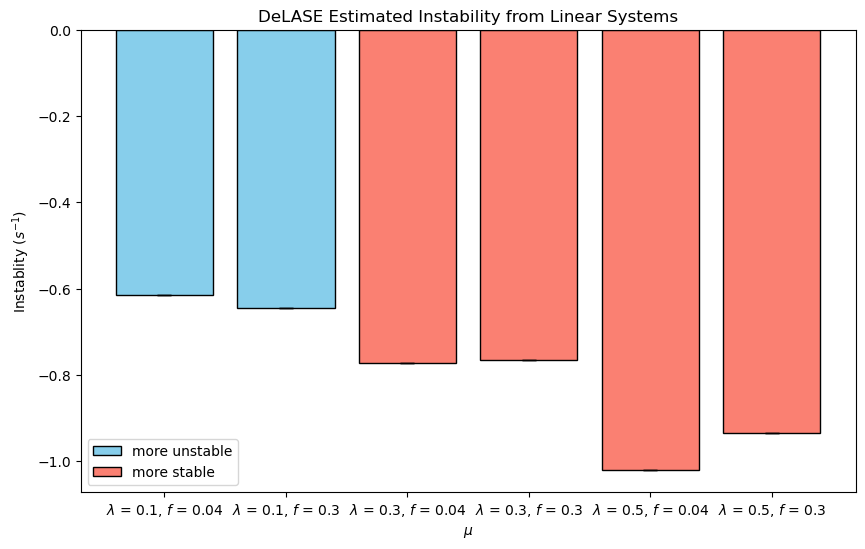

In [216]:
plt.figure(figsize=(10, 6))

stab_means = np.zeros((num_trajs, len(pairs_to_use)))

for num_traj, delase_results in enumerate(all_delase_results):
    labels = []
    for ind, (decay_rate, freq) in enumerate(pairs_to_use):
        stab_params = delase_results[(decay_rate, freq)]['delase'].stability_params
        stab_means[num_traj, ind] = stab_params[:int(0.1*len(stab_params))].mean()

# Create the scatter plot with error bars
mean_vals = stab_means.mean(axis=0)
se_vals = stab_means.std(axis=0)/np.sqrt(stab_means.shape[0])

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
color_dict = {decay_rate'skyblue'
colors = ['skyblue' if decay_rate == np.min(decay_rates) else 'salmon' for decay_rate, freq in pairs_to_use]
plt.bar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
plt.xticks(np.arange(len(pairs_to_use)), [fr"$\lambda$ = {decay_rate}, $f$ = {freq}" for decay_rate, freq in pairs_to_use])

plt.xlabel("$\mu$")
plt.ylabel("Instablity ($s^{-1}$)")

plt.title("DeLASE Estimated Instability from Linear Systems")

# Create legend
# legend_labels = {'more unstable': 'more unstable', 'more stable': 'more stable'}
# legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['more unstable']),
#                   plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['more stable'])]
# plt.legend(handles=legend_handles, loc='lower left')

# Display the plot
# clear_axes(plt.gca())
plt.show()

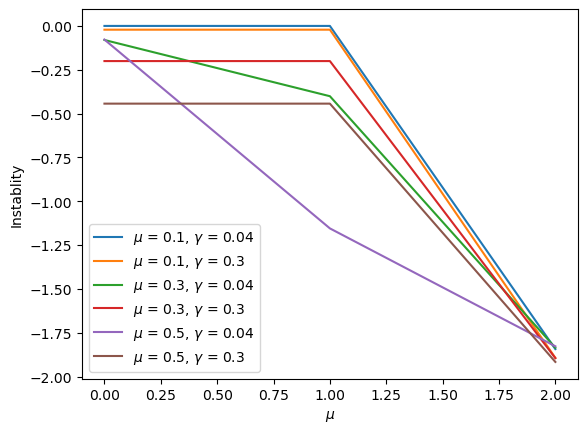

In [217]:
top_percent = 0.1

stab_means = np.zeros((num_trajs, len(pairs_to_use), int(top_percent*len(stab_params))))

for num_traj, delase_results in enumerate(all_delase_results):
    labels = []
    for ind, (mu, gamma) in enumerate(pairs_to_use):
        stab_params = delase_results[(mu, gamma)]['delase'].stability_params
        stab_means[num_traj, ind] = stab_params[:int(top_percent*len(stab_params))].cpu()

# Create the scatter plot with error bars
mean_vals = stab_means.mean(axis=0)
se_vals = stab_means.std(axis=0)/np.sqrt(stab_means.shape[0])

for ind, (mu, gamma) in enumerate(pairs_to_use):
    plt.plot(mean_vals[ind], label=fr"$\mu$ = {mu}, $\gamma$ = {gamma}")
    plt.fill_between(np.arange(len(mean_vals[ind])), mean_vals[ind] - se_vals[ind], mean_vals[ind] + se_vals[ind], alpha=0.5)
plt.xlabel("$\mu$")
plt.ylabel("Instablity")
# Display the plot
plt.legend()
plt.show()